In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
# pd.set_option('display.max_rows',None)

적당한 머지 이후 
> 유저별로 충성도를 확인 (시간 / 횟수 / 구매) 해볼 필요가 있음

# 1) history_data.csv : 시청 시작 데이터
![image](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/2b762359-78b9-470c-9369-5d1b3d9ff06f..png)

profile_id 8,311명의 유저가 100만건의 시청기록을 만들었다.    

act_target_dtl 의 모든 값은 -003으로 통일.   

album_id  20,695개의 동영상이 100만건 가량의 시청기록을 만들었다.    

continuous_play는 9:1 정도의 class imbalance를 보인다.     

short_trailer는 추천에 큰 영향을 미치지 않을 것으로 에상된다.     

payment 금액 분포가 수상하다. 단지 동영상 구매뿐만이 아니라 체험학습 구매나 예약 등도 같이 이뤄진 게 아닌가?   

> 시청 종료 데이터와 merge할 수 있을까? 

### 2022년 3월 1일부터~ 2022년 4월 27일까지의 데이터

In [2]:
history = pd.read_csv('../input/lgground/history_data.csv')
history['payment'].fillna(0,inplace=True)

In [3]:
history

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,0.0,Y,N
1,3,20220301115653,20220301115809,MKID003,16,0.0,Y,N
2,3,20220301115653,20220301115958,MKID003,17,0.0,Y,N
3,3,20220301115653,20220301120118,MKID003,18,0.0,Y,N
4,3,20220301115653,20220301120229,MKID003,19,0.0,Y,N
...,...,...,...,...,...,...,...,...
1005646,33032,20220427155091,20220427155668,MKID003,381,0.0,Y,N
1005647,33032,20220427155091,20220427155680,MKID003,381,0.0,Y,N
1005648,33032,20220427155839,20220427155810,MKID003,125,0.0,Y,N
1005649,33032,20220427155706,20220427155838,MKID003,125,0.0,Y,N


In [4]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005651 entries, 0 to 1005650
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   profile_id       1005651 non-null  int64  
 1   ss_id            1005651 non-null  int64  
 2   log_time         1005651 non-null  int64  
 3   act_target_dtl   1005651 non-null  object 
 4   album_id         1005651 non-null  int64  
 5   payment          1005651 non-null  float64
 6   continuous_play  1005651 non-null  object 
 7   short_trailer    1005651 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 61.4+ MB


In [5]:
# 세션 ID 개수와 동영상 ID 개수가 일치한가?  ==  중복시청기록이 남아 있는가?
history.groupby(['profile_id']).count()

# a = history.groupby(['profile_id'])['album_id'].count().sort_values()
# a.tail(20)
# b = pd.DataFrame(history.groupby(['profile_id'])['ss_id'].count().sort_values())
# b.tail(20)

,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
profile_id,,,,,,,
3,21,21,21,21,21,21,21
5,550,550,550,550,550,550,550
7,2,2,2,2,2,2,2
12,7,7,7,7,7,7,7
16,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...
33022,2,2,2,2,2,2,2
33023,12,12,12,12,12,12,12
33026,1,1,1,1,1,1,1


>> 중복 시청 기록은 데이터에 없다. <<
세션 수 == 동영상 ID 수.     
숫자 차이가 났다면,(세션 수 > 동영상 ID 였다면 중복시청기록이 데이터에 남아 있다는 뜻)

In [6]:
# 최다시청자를 찾아보자 / 시청분포확인
# id 3847,2794는 무서울 정도로 많이 봐서 우선 제외 (14014, 18190편씩 봄)
# pd.DataFrame(history.groupby(['profile_id'])['album_id'].count().sort_values())

a = pd.DataFrame(history.groupby(['profile_id'])['album_id'].count().sort_values().drop([3847,2794]))
a

,album_id
profile_id,
26344,1
23766,1
28292,1
16254,1
16288,1
...,...
10241,4490
22292,4827
6107,5495


### submission file의 row 수  : 8311명

In [7]:
num_hispro = history['profile_id'].nunique()
num_albpro = history['album_id'].nunique()
num_paypro = history['payment'].count()
print(f"시작 프로필 수 : {num_hispro}")
print(f"시작 아이템 수 : {num_albpro}")
print(f"구매 수 : {num_paypro}")

시작 프로필 수 : 8311
시작 아이템 수 : 20695
구매 수 : 1005651


In [8]:
pd.DataFrame(history['payment'].value_counts())
# 금액분포 무슨일임?
# 실제 동영상 가격일지 확인하는 작업이 필요할지도 모르겠다. 또한 Nan도 다수 있다. 
# 가격이 0인 동영상이 없다. > 0원 == NaN  위에서 결측치 채워버리고 해결.
# 가격 높은 동영상 =?= 부모용 컨텐츠?

,payment
0.0,932165
500.0,46037
5040.0,8588
300.0,6782
5900.0,3976
700.0,1599
2500.0,1508
20000.0,1253
14000.0,919
9900.0,785


Y    889517
N    116134
Name: continuous_play, dtype: int64


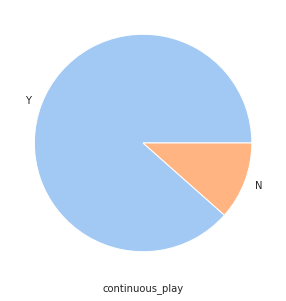

In [9]:
pie_data = history['continuous_play'].value_counts()
print(pie_data)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
colors = sns.color_palette('pastel')
ax.pie(pie_data, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('continuous_play')
plt.show()

# 거의 모든 시청이 '연속 시청'으로 이루어진다.

# 2) watch_e_data.csv : 시청 종료 데이터
![watch](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/81a5741f-9481-49ed-8533-1e62d5f9fb50..png)

시청 시작 데이터와 시청 종료 데이터 사이의 row 개수 차이가 심각함. 112,857개 차이가 난다.   

profile_id 에서도 nunique가 시작 데이터보다 종료 데이터가 635명 적다.   

album_id 도   nunique (20695 - 20361) 334개 더 적다.   

watch_time 은 적절한 구간별 전처리가 필요함. 실수값이 심하다. 게다가 빈도로 20개를 확인했을 때, 시청시간 0초~7초가 너무 많다. 이걸 다 neg sampling으로 하기에도 애매하다. 영상 최대 4769초(79분짜리) 시청.    
> 잘못 틀었다가 다른 것으로 넘긴 것인지 확인이 필요 (continuous play와 연계한 파악이 가능한지?) 

total_time 의 최대 영상 길이는 8929초 (149분). 평균적으로 271초(4.5분). Box plot으로 분포나 아웃라이어 확인해볼 필요가 있다.   

continuous_play 는 1(연속재생)이 과반수인 5만건을 차지하며, 0(이후 재생 없음)은 3만건을 차지한다. 이 column은 무의미하다고 보여진다. **중요한 건, 절반 이상의 유저가 연속재생으로 컨텐츠를 소비하고 있다는 점**이다.    

In [10]:
watch = pd.read_csv('../input/lgground/watch_e_data.csv')
watch

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1
3,3,20220301115653,20220301120226,MKID049,18,67,68,1
4,3,20220301115653,20220301120400,MKID049,19,90,90,0
...,...,...,...,...,...,...,...,...
892789,33032,20220427155091,20220427155653,MKID049,381,463,464,1
892790,33032,20220427155091,20220427155694,MKID049,381,462,463,1
892791,33032,20220427155839,20220427155826,MKID049,125,10,520,0
892792,33032,20220427155706,20220427155836,MKID049,125,6,521,0


In [11]:
watch.info()
# 시청 시작 데이터와 row 갯수 차이가 심각함. 112,857개 차이가 난다. (merge 불가능하지 않아?)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892794 entries, 0 to 892793
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   profile_id       892794 non-null  int64 
 1   ss_id            892794 non-null  int64 
 2   log_time         892794 non-null  int64 
 3   act_target_dtl   892794 non-null  object
 4   album_id         892794 non-null  int64 
 5   watch_time       892794 non-null  int64 
 6   total_time       892794 non-null  int64 
 7   continuous_play  892794 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 54.5+ MB


In [12]:
watpro = watch['profile_id'].nunique()
print(f"종료 프로필 수 : {watpro}")
watalb = watch['album_id'].nunique()
print(f"종료 아이템 수 : {watalb}")

# 시작 프로필 수 : 8311  (653개 차이)
# 시작아이템 수 : 20695 (334개 차이)

종료 프로필 수 : 7658
종료 아이템 수 : 20361


In [13]:
watch['watch_time'].describe()

# 시청 시간 기초통계량 확인 (초 단위)
# 최대 시청 시간 : 4769 초

count    892794.000000
mean        185.089239
std         219.155164
min           0.000000
25%          34.000000
50%         100.000000
75%         298.000000
max        4769.000000
Name: watch_time, dtype: float64

In [14]:
watch_df = pd.DataFrame(watch['watch_time'].reset_index(drop=True))
# watch_df = pd.DataFrame(watch_df, columns='watch_time')
watch_df

# 시청시간 전체의 분포를 확인하기 위한 작업 

,watch_time
0,46
1,104
2,76
3,67
4,90
...,...
892789,463
892790,462
892791,10
892792,6


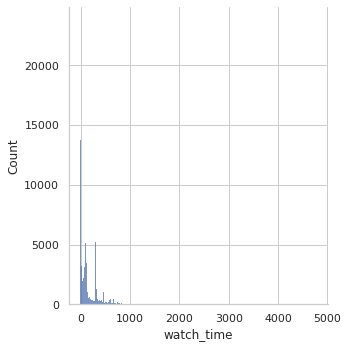

In [15]:
sns.set_theme(style='whitegrid')
 
ax = sns.displot(data=watch_df, x='watch_time', binwidth=3,stat="count", discrete=True)

In [16]:
pd.DataFrame(watch.groupby(['profile_id']).count()['watch_time'].sort_values())

# 유저당 시청 횟수 (프로필 id 별로 시청횟수 집계)
# 최다 시청횟수 13189 . 최소 시청횟수 1

,watch_time
profile_id,
20630,1
13210,1
6564,1
17596,1
9854,1
...,...
6155,5489
13450,5838
6107,5867


In [17]:
# cold start 유저 목록 뽑기

cold_watcher = pd.DataFrame(watch.groupby(['profile_id']).count()['watch_time'].sort_values())
cold_watcher.describe()

,watch_time
count,7658.000000
mean,116.583181
std,342.640290
min,1.000000
25%,10.000000
50%,36.000000
75%,104.000000
max,13189.000000


In [18]:
cold_watcher_34 = cold_watcher[(cold_watcher['watch_time']<34)].reset_index()
cold_watcher_34
# 348명의 cold start 유저 존재 (threshold 1)
# 하위 25% 미만은 cold 하다고 가정? << 이 가정이 맞을지는 추후 확인  ( 이 경우, threshold 33. 3712명이 cold 하다는 판단이 됨)

######## cold start 유저 리스트 따로 뽑아두기  
df_dict = cold_watcher_34.to_dict()
dic_cold = df_dict['profile_id'].values()
coldlist = list(dic_cold)
# coldlist

# 특히 영상 총 시간이 긴 item의 장르, 제목이 무엇인지 확인해 볼 필요 있음 <아래 참조>  

In [19]:
watch['total_time'].value_counts()[:30]

# 동영상 최대 길이가 얼마나 되는지 가볍게 확인

185    27614
301    17038
105    16733
305    13771
661    13012
300    12722
103    10837
95     10814
186    10634
665     9442
94      9251
98      8659
97      7973
90      7937
68      7738
91      7458
96      7274
99      7203
121     7046
46      6993
76      6545
666     6466
93      6100
660     6077
80      5840
92      5650
299     5472
100     5295
667     5109
88      4866
Name: total_time, dtype: int64

In [20]:
watch['total_time'].describe()

## 최대 시간이 149분이면 이건 100% 부모용 영상이다 

count    892794.000000
mean        338.502926
std         346.333053
min          19.000000
25%         104.000000
50%         271.000000
75%         478.000000
max        8929.000000
Name: total_time, dtype: float64

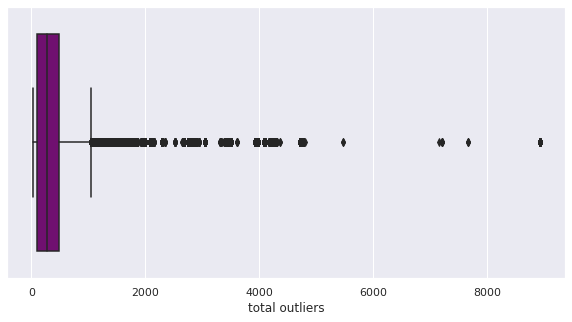

In [21]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=watch, x='total_time', color='purple')
ax.set_xlabel('total outliers')
plt.show()

In [22]:
watch['continuous_play'].value_counts()

1    500524
0    312677
2     79424
3       169
Name: continuous_play, dtype: int64

In [23]:
play_df = pd.DataFrame(watch['continuous_play'].value_counts().reset_index()) 

In [24]:
play_df = pd.DataFrame(watch['continuous_play'].value_counts().reset_index()) 
type=['이후 컨텐츠 재생 없음','연속재생','선택에 의한 종료','기타 종료']

# 3) buy_data.csv : 구매 이력 데이터

![column](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/84d3a789-1a48-46fa-87df-3fcd42efd28b..png)


profile_id의 nquniqe는 전체 17명밖에 되지 않는다. 150건의 구매를 17명이 냈다는 뜻.   
   
ss_id와 log_time 2개 column은 시간적으로 큰 차이가 안 난다. 특별한 의미가 없어 보인다. 두 column중 하나만 남겨서, merge혹은 train-test split에 사용하면 될 듯. *다만 시청 log_time의 경우에는 새로운 추천BM 제안(시간대별 추천 등)에는 쓸모가 있을지도 모른다.*    
    ㄴ참조 : 새로운 추천 아이디어 및 프로필별 맞춤형 콘텐츠 추천 AI 모델을 개발하는 AI 경진대회입니다.   
   
MKID004은 unique한 값이 1개인 column하다. Drop 해도 될 듯.
   
Payment column은 가격이 구매영상 선택과 추천에 있어 중요한 요소가 될 수도 있다는 점을 시사하고, 가격이 특히 높은 것이 무엇이었는지 확인해 볼 필요도 있어 보인다.    
300~500원대 영상이 가장 많이 구매되었다.    
> 확인해볼것+ 구매하지 않아도 볼 수 있는 영상/구매해야만 볼 수 있는 영상이 나뉘어 있을지도 모름    

In [25]:
buy = pd.read_csv('../input/lgground/buy_data.csv')
buy.sort_values('ss_id')

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment
113,15000,20220301135705,20220301140041,MKID004,4959,500
11,5629,20220308121025,20220308121154,MKID004,17873,6300
12,5629,20220308121025,20220308121154,MKID004,17873,6300
13,7394,20220308182618,20220308182750,MKID004,4723,500
1,1603,20220309163919,20220309164043,MKID004,1640,300
...,...,...,...,...,...,...
104,10416,20220426201807,20220426203725,MKID004,16677,500
105,10416,20220426201807,20220426210010,MKID004,3467,700
103,10416,20220426201807,20220426203033,MKID004,7214,500
112,14035,20220427102836,20220427104140,MKID004,712,300


In [26]:
buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   profile_id      150 non-null    int64 
 1   ss_id           150 non-null    int64 
 2   log_time        150 non-null    int64 
 3   act_target_dtl  150 non-null    object
 4   album_id        150 non-null    int64 
 5   payment         150 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 7.2+ KB


In [27]:
buypro = buy['profile_id'].nunique()
print(f"구매 유저 명수 : {buypro}명")
buyalb = buy['album_id'].nunique()
print(f"구매된 영상 개수 : {buyalb}개")

구매 유저 명수 : 17명
구매된 영상 개수 : 126개


In [31]:
# 구매된 영상의 이름, 장르, 카테고리 확인   ##### Meta 데이터셋과 머지
buy_df = pd.merge(buy, meta, on = 'album_id', how = 'left').drop(labels=['ss_id','log_time','genre_mid','genre_small','onair_date','cast_2','cast_3','cast_4','cast_5','cast_6','cast_7'],axis=1)

In [32]:
# 판매 금액대별로 묶기 
buy_popular = buy_df.groupby(['payment','album_id']).count().drop(labels=['act_target_dtl','title','sub_title','genre_large','country','run_time','cast_1'],axis=1)
buy_popular

profile_id
payment album_id            
300     712                1
        804                1
        915                1
        1638               2
        1639               2
...                      ...
1400    8437               1
1500    12166              4
2500    3460               8
4200    10454              1
6300    17873              2

[126 rows x 1 columns]

In [33]:
# 판매 금액대별로 묶은 것들 확인했으니, 이제 dict 형식으로 저장해두기.   <album ID - 판매 횟수 >
buy_alid = buy_popular.reset_index().drop(labels='payment',axis=1).rename(columns={'profile_id':'buy_count'})
buy_alid_dict =  buy_alid.to_dict('list')

# buy_df (메인 머지) 데이터프레임에 구매 횟수 column 추가해두기 <추후 meta 데이터셋에 추가되어야 하는 내용> 
buy_count = pd.DataFrame.from_dict(buy_alid_dict)
buy_df = pd.merge(buy_df, buy_count, on = 'album_id', how = 'left')
buy_df

,profile_id,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,cast_1,buy_count
0,255,MKID004,3767,500,엘리 의사! 공주들의 울음을 멈춰줘!,엘리가 간다27,키즈,한국,383,엘리,1
1,1603,MKID004,1640,300,뿡뿡 화장실 숨바꼭질,핑크퐁 상어가족 숨바꼭질,키즈,한국,338,핑크퐁,5
2,5303,MKID004,3821,500,"웃어봐, 티라노",고고다이노 공룡탐험대4,키즈,한국,667,렉스,1
3,5303,MKID004,3822,500,도망쳐! 알로사우루스,고고다이노 공룡탐험대4,키즈,한국,666,렉스,1
4,5303,MKID004,3823,500,타르보사우루스의 비밀,고고다이노 공룡탐험대4,키즈,한국,674,렉스,1
...,...,...,...,...,...,...,...,...,...,...,...
166,23882,MKID004,7441,300,공룡 놀이터를 만들자,뽀로로와 공룡 친구들,키즈,한국,200,뽀로로,2
167,23882,MKID004,8749,1200,뽀로로와 루피의 모험,뽀로로와 루피의 모험,키즈,한국,1487,뽀로로,1
168,31509,MKID004,19906,500,환상의 짝꿍,꼬마버스 타요5(영어),키즈,한국,665,NaN,1
169,31837,MKID004,1640,300,뿡뿡 화장실 숨바꼭질,핑크퐁 상어가족 숨바꼭질,키즈,한국,338,핑크퐁,5


In [34]:
buy_df['payment'].unique()

array([ 500,  300, 6300, 4200, 1200, 1400, 2500, 1500,  700])

In [35]:
buy_df[(buy_df['payment']==6300)]

,profile_id,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,cast_1,buy_count
11,5629,MKID004,17873,6300,"냠냠, 밥상 놀이",토끼가 까꿍,키즈,한국,622,NaN,2
12,5629,MKID004,17873,6300,"냠냠, 밥상 놀이",토끼가 까꿍,키즈,한국,622,NaN,2


In [36]:
buy_df[(buy_df['payment']==4200)]

,profile_id,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,cast_1,buy_count
29,8410,MKID004,10454,4200,똑똑한 앵무새 폴리 외(영어),페파피그3(영어),키즈,영국,571,페파,1


In [37]:
buy_df[(buy_df['payment']==2500)]

,profile_id,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,cast_1,buy_count
34,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,극장판,영화,한국,4768,뽀로로,8
35,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,전체보기,영화,한국,4768,뽀로로,8
55,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,극장판,영화,한국,4768,뽀로로,8
56,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,전체보기,영화,한국,4768,뽀로로,8
87,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,극장판,영화,한국,4768,뽀로로,8
88,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,전체보기,영화,한국,4768,뽀로로,8
103,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,극장판,영화,한국,4768,뽀로로,8
104,10416,MKID004,3460,2500,뽀로로 극장판 보물섬 대모험,전체보기,영화,한국,4768,뽀로로,8


In [38]:
buy_df[(buy_df['payment']==1500)]

,profile_id,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,cast_1,buy_count
47,10416,MKID004,12166,1500,클레이 바다동물 만들기,노래율동,키즈,한국,2786,NaN,4
48,10416,MKID004,12166,1500,클레이 바다동물 만들기,전체보기,키즈,한국,2786,NaN,4
61,10416,MKID004,12166,1500,클레이 바다동물 만들기,노래율동,키즈,한국,2786,NaN,4
62,10416,MKID004,12166,1500,클레이 바다동물 만들기,전체보기,키즈,한국,2786,NaN,4


In [39]:
# 가장 많이 팔린 횟수는? 
buy_df['buy_count'].value_counts()

# 1회 구매가 압도적으로 많음 

1    101
2     36
4     12
8      8
6      6
5      5
3      3
Name: buy_count, dtype: int64

In [40]:
# 판매에 기여한 캐릭터 순위 확인 (인기 캐릭터 순위)

################ 뽀로로 > 핑크퐁 > 콩순이 > 렉스 > 폴리 

# 나이별 인기 캐릭터 순위도 확인 필요 

buy_df.groupby(['cast_1']).count()

,profile_id,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,buy_count
cast_1,,,,,,,,,,
꼬마캐빈,1,1,1,1,1,1,1,1,1,1
디디,1,1,1,1,1,1,1,1,1,1
띠띠뽀,1,1,1,1,1,1,1,1,1,1
렉스,10,10,10,10,10,10,10,10,10,10
무스티,1,1,1,1,1,1,1,1,1,1
보보,1,1,1,1,1,1,1,1,1,1
볼트,9,9,9,9,9,9,9,9,9,9
뽀로로,48,48,48,48,48,48,48,45,48,48
뽀로로와 친구들,1,1,1,1,1,1,1,1,1,1


In [41]:
buy['payment'].describe()

count     150.000000
mean      706.000000
std       843.469186
min       300.000000
25%       300.000000
50%       500.000000
75%       500.000000
max      6300.000000
Name: payment, dtype: float64

In [42]:
pd.DataFrame(buy['payment'].value_counts())

,payment
500,63
300,52
1200,16
700,6
1400,4
2500,4
6300,2
1500,2
4200,1


In [43]:
# 최다 구매 유저 <충성고객>
buy_df.groupby(['profile_id']).count().sort_values('act_target_dtl',ascending=False)[:11]

,act_target_dtl,album_id,payment,title,sub_title,genre_large,country,run_time,cast_1,buy_count
profile_id,,,,,,,,,,
10416,96,96,96,96,96,96,87,96,70,96
16379,13,13,13,13,13,13,13,13,13,13
7394,12,12,12,12,12,12,11,12,12,12
23882,11,11,11,11,11,11,11,11,11,11
5303,9,9,9,9,9,9,9,9,9,9
8410,6,6,6,6,6,6,6,6,5,6
17507,6,6,6,6,6,6,5,6,5,6
12472,5,5,5,5,5,5,5,5,5,5
15000,4,4,4,4,4,4,3,4,4,4


# 4) search_data.csv : 검색을 통한 시청 데이터
![search](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/4fdc2a58-e698-4bbc-b2a7-ffa20ccb6a61..png)

In [44]:
search = pd.read_csv('../input/lgground/search_data.csv')

In [45]:
ser_df = pd.merge(search, meta, on = 'album_id', how = 'left').drop(labels=['ss_id','log_time','genre_mid','genre_small','onair_date','cast_2','cast_3','cast_4','cast_5','cast_6','cast_7'],axis=1)
ser_df

,profile_id,act_target_dtl,album_id,title,sub_title,genre_large,country,run_time,cast_1
0,59,MKID017,2141,귀가 뻥! 이야기가 쏙쏙!,키즈스콜레,키즈,한국,510,NaN
1,59,MKID017,2141,귀가 뻥! 이야기가 쏙쏙!,키즈스콜레,키즈,한국,510,NaN
2,59,MKID017,2141,귀가 뻥! 이야기가 쏙쏙!,키즈스콜레,키즈,한국,510,NaN
3,59,MKID017,512,피노키오,키즈스콜레,키즈,한국,524,NaN
4,59,MKID017,2141,귀가 뻥! 이야기가 쏙쏙!,키즈스콜레,키즈,한국,510,NaN
...,...,...,...,...,...,...,...,...,...
7489,32965,MKID017,23083,치키포키 공룡가족,퓨처북 공룡 동요2,키즈,한국,128,NaN
7490,32965,MKID017,15080,빨간 모자,주니토니 NEW 동화뮤지컬,키즈,한국,492,주니
7491,32965,MKID017,15080,빨간 모자,주니토니 NEW 동화뮤지컬,키즈,한국,492,주니
7492,32965,MKID017,16497,학교,주니토니 어쩌다 암기왕 두잇두잇 언어왕,키즈,한국,157,주니


In [46]:
seapro = search['profile_id'].nunique()
print(f"검색 시도한 유저 명수 : {seapro}")
seaalb = search['album_id'].nunique()
print(f"검색된 아이템 개수 : {seaalb}")

검색 시도한 유저 명수 : 644
검색된 아이템 개수 : 1977


In [47]:
# 최다검색유저
ser_df.groupby(['profile_id']).count().sort_values('act_target_dtl',ascending=False)[:30]

,act_target_dtl,album_id,title,sub_title,genre_large,country,run_time,cast_1
profile_id,,,,,,,,
14379,298,298,298,298,298,217,298,271
9368,217,217,217,217,217,189,217,34
14943,204,204,204,204,204,167,204,83
22292,196,196,196,196,196,196,196,146
31706,160,160,160,160,160,152,160,55
16990,150,150,150,150,150,134,150,45
30896,125,125,125,125,125,122,125,6
25750,108,108,108,108,108,108,108,0
6107,98,98,98,98,98,82,98,39


In [48]:
# 가장 많이 검색된 동영상 top 30

ser_df.groupby(['album_id']).count().sort_values('profile_id',ascending=False)[:30]

,profile_id,act_target_dtl,title,sub_title,genre_large,country,run_time,cast_1
album_id,,,,,,,,
347,236,236,236,236,236,236,236,0
1880,172,172,172,172,172,172,172,0
4325,107,107,107,107,107,107,107,0
348,86,86,86,86,86,86,86,0
2337,64,64,64,64,64,64,64,0
2484,60,60,60,60,60,60,60,0
2159,52,52,52,52,52,52,52,52
524,49,49,49,49,49,49,49,49
513,48,48,48,48,48,48,48,0


In [49]:
# 자주 검색된 장르 확인

ser_df['genre_large'].value_counts()

키즈    6979
애니     476
영화      29
다큐       5
방송       5
Name: genre_large, dtype: int64

In [50]:
# 많이 검색된 title 순위
pd.DataFrame(ser_df['title'].value_counts()[:20])

,title
알사탕,236
장수탕 선녀님,172
또봇 애슬론,107
이상한 엄마,86
야구장 가는 날,64
사랑해 사랑해 사랑해,60
꼬마장수말벌 관찰 외,52
엉망진창 쿠키 만들기,49
헨젤과 그레텔,48
백설 공주,46


In [51]:
pd.DataFrame(ser_df['sub_title'].value_counts()[:20])

,sub_title
4-5세,666
6-7세,579
키즈스콜레,455
3세이하,251
[아동심리전문가 추천] 따뜻한 이야기를 들려주세요,238
대교상상동화,203
캐치! 티니핑 1,170
토이푸딩 남아 토이쇼2,146
한글용사 아이야,139
또보는노부영,125


# 검색도 많이 되고 구매도 많이 된 영상 목록 확인 필요

# 5) meta_data.csv : 콘텐츠 일반 메타 정보
![meta](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/945112b2-71b4-43a5-bb57-ef4b49fe6bff..png)

In [52]:
meta = pd.read_csv('../input/lgground/meta_data.csv')
meta

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42597,39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,로티프렌즈 미술놀이,키즈,놀이교실,NaN,한국,477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42598,39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,로티프렌즈 미술놀이,키즈,놀이교실,NaN,한국,466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42599,4779,손가락을 빨게 돼요,4-5세,키즈,책,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42600,4779,손가락을 빨게 돼요,아이맘콕,키즈,책,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42602 entries, 0 to 42601
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   album_id     42602 non-null  int64  
 1   title        42602 non-null  object 
 2   sub_title    42602 non-null  object 
 3   genre_large  42602 non-null  object 
 4   genre_mid    42602 non-null  object 
 5   genre_small  13419 non-null  object 
 6   country      33734 non-null  object 
 7   run_time     42602 non-null  int64  
 8   onair_date   5344 non-null   float64
 9   cast_1       27603 non-null  object 
 10  cast_2       22048 non-null  object 
 11  cast_3       16463 non-null  object 
 12  cast_4       12485 non-null  object 
 13  cast_5       6382 non-null   object 
 14  cast_6       2609 non-null   object 
 15  cast_7       762 non-null    object 
dtypes: float64(1), int64(2), object(13)
memory usage: 5.2+ MB


In [54]:
meta['album_id'].nunique()  #
print()

In [55]:
meta['title'].nunique()

# 이거 album_id가 3천개 가량 더 많다? 한 영상에 여러 개의 id가 할당되어 있는듯

36185

In [56]:
meta['cast_1'].value_counts()  #역시 뽀통령

뽀로로         1628
핑크퐁         1201
키키           996
캐리           792
타요           656
            ... 
슈노사우루스         1
디모르포돈          1
프시타코사우루스       1
키우딥테릭스         1
해마             1
Name: cast_1, Length: 689, dtype: int64

# 6) meta_data_plus.csv : 콘텐츠 확장 정보
![meplus](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00001436/files/d1c0ed82-8e75-440d-91e8-e765c8f31d89..png)

In [57]:
metaplus = pd.read_csv('../input/lgground/meta_data_plus.csv')
metaplus

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
1,749,05010302,EBS,0
2,749,05010401,3세,0
3,749,05010402,4세,0
4,749,05010407,1세,0
...,...,...,...,...
767943,11629,05040104,신나는,0
767944,11629,0504010b,따라하고 싶은,0
767945,11629,05070e01,인체,0
767946,11629,05080401,캐릭터 친구들,0


In [58]:
metaplus['keyword_type'].nunique()

1101

In [59]:
metaplus['keyword_name'].nunique()

# 태그코드 고유값이 태크코드명보다 40개 가량 많다. 

1062

# 7) profile_data.csv : 프로필 정보
![profile](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/a3c750f4-b97d-488f-aaea-ef0e334b86e5..png)

profile_id 8311개    

sex 성비는 여아가 600명 가량 더 많았다.   

age  최소나이 1살, 최대나이 13살. 3~8살 사이가 70% 가량을 차지한다.   

pr_interest_keyword_cd_1 부모의 선호 키워드 순위는 6>2>>>1>7>3   

ch_interest_keyword_cd_1 아이의 선호 키워드 순위는 1>>>>>>2>3>>46


In [60]:
profile = pd.read_csv('../input/lgground/profile_data.csv')
profile

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
...,...,...,...,...,...,...,...,...,...
8306,33022,M,1,P04,NaN,NaN,K04,K08,NaN
8307,33023,M,5,P06,P03,P07,K08,K04,K05
8308,33026,F,8,P01,P03,P08,K05,K09,K06
8309,33027,F,4,P04,P05,P06,K03,K01,K05


In [61]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8311 entries, 0 to 8310
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   profile_id                8311 non-null   int64 
 1   sex                       8311 non-null   object
 2   age                       8311 non-null   int64 
 3   pr_interest_keyword_cd_1  8311 non-null   object
 4   pr_interest_keyword_cd_2  6778 non-null   object
 5   pr_interest_keyword_cd_3  6231 non-null   object
 6   ch_interest_keyword_cd_1  8311 non-null   object
 7   ch_interest_keyword_cd_2  6618 non-null   object
 8   ch_interest_keyword_cd_3  6029 non-null   object
dtypes: int64(2), object(7)
memory usage: 584.5+ KB


In [62]:
profile['age'].describe()

count    8311.000000
mean        5.619540
std         2.407844
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        13.000000
Name: age, dtype: float64

In [63]:
pie_data = profile[['profile_id', 'age']].groupby('age').count()

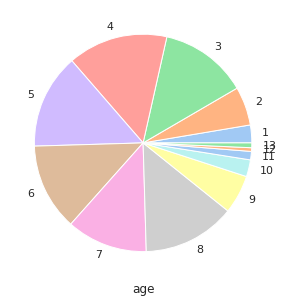

In [64]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
colors = sns.color_palette('pastel')
ax.pie(pie_data.profile_id, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('age')
plt.show()

In [65]:
profile['sex'].value_counts()

F    4431
M    3880
Name: sex, dtype: int64

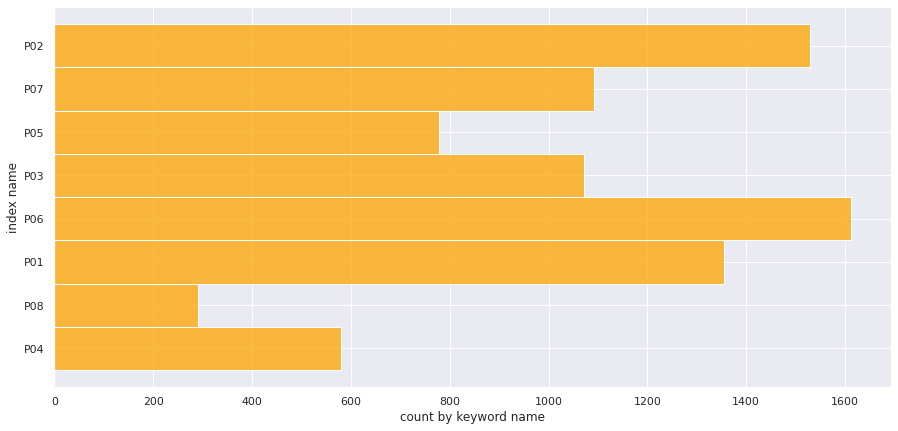

In [66]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=profile, y='pr_interest_keyword_cd_1', color='orange')
ax.set_xlabel('count by keyword name')
ax.set_ylabel('index name')
plt.show()

In [67]:
profile['pr_interest_keyword_cd_1'].value_counts()

P06    1613
P02    1530
P01    1355
P07    1093
P03    1071
P05     779
P04     580
P08     290
Name: pr_interest_keyword_cd_1, dtype: int64

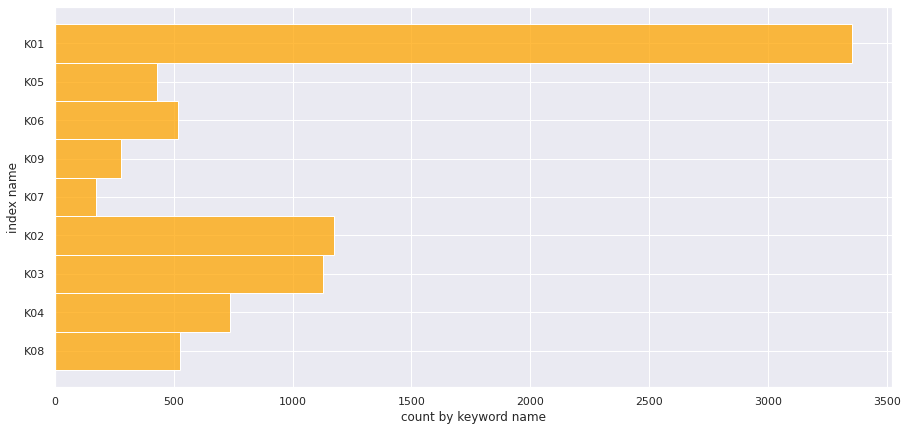

In [68]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=profile, y='ch_interest_keyword_cd_1', color='orange')
ax.set_xlabel('count by keyword name')
ax.set_ylabel('index name')
plt.show()

In [69]:
profile['ch_interest_keyword_cd_1'].value_counts()

K01    3354
K02    1173
K03    1126
K04     738
K08     525
K06     517
K05     431
K09     276
K07     171
Name: ch_interest_keyword_cd_1, dtype: int64

In [70]:
# 나이별 선호 키워드 확인해보기 (아이들)
pd.set_option('display.max_rows',None)

In [71]:
pd.DataFrame(profile.groupby(['age','ch_interest_keyword_cd_1']).count()['profile_id']) #이쁘게 만든다 

profile_id
age ch_interest_keyword_cd_1            
1   K01                               61
    K02                               30
    K03                               33
    K04                               21
    K05                                8
    K06                               10
    K07                                9
    K08                               31
    K09                               17
2   K01                              358
    K02                               29
    K03                               30
    K04                               12
    K05                                7
    K06                               11
    K07                                8
    K08                                9
    K09                               14
3   K01                              805
    K02                              132
    K03                               41
    K04                                8
    K05                                6
    K06                                9
    K07                               14
    K08                               55
    K09                               18
4   K01                              707
    K02                              142
    K03                              106
    K04                               23
    K05                               28
    K06                               57
    K07                               16
    K08                              132
    K09                               26
5   K01                              494
    K02                              153
    K03                              176
    K04                               43
    K05                               60
    K06                               81
    K07                               19
    K08                              118
    K09                               28
6   K01                              314
    K02                              172
    K03                              176
    K04                               96
    K05                               88
    K06                               91
    K07                               25
    K08                               78
    K09                               36
7   K01                              237
    K02                              174
    K03                              187
    K04                              143
    K05                               77
    K06                               82
    K07                               20
    K08                               45
    K09                               36
8   K01                              246
    K02                              178
    K03                              230
    K04                              206
    K05                               87
    K06                               92
    K07                               31
    K08                               36
    K09                               39
9   K01                               66
    K02                               83
    K03                               88
    K04                              106
    K05                               39
    K06                               44
    K07                               12
    K08                               14
    K09                               26
10  K01                               28
    K02                               40
    K03                               31
    K04                               44
    K05                               20
    K06                               20
    K07                                9
    K08                                5
    K09                               11
11  K01                               14
    K02                               21
    K03                               14
    K04                               19
    K05                                7
    K06                               12
    K07     